### Table of Contents  
[1. Import data](#1)  
[2. Exploratory data analysis](#2)  
[3. Add features](#3)  
[4. Tf-idf/cluster](#4)  

In [438]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans

%matplotlib inline

### <a id='1'></a> 1. Import data and convert to df

In [91]:
with open('tweets/donald_tweets.pkl', 'r') as picklefile:
    dt_data = pickle.load(picklefile)

with open('tweets/hillary_tweets.pkl', 'r') as picklefile:
    hc_data = pickle.load(picklefile)
    
with open('tweets/bernie_tweets.pkl', 'r') as picklefile:
    bs_data = pickle.load(picklefile)
    
with open('tweets/cruz_tweets.pkl', 'r') as picklefile:
    tc_data = pickle.load(picklefile)

with open('tweets/rubio_tweets.pkl', 'r') as picklefile:
    mr_data = pickle.load(picklefile)

In [95]:
def data_to_df(data, name):
    """Convert list object of tweet data into dataframe; keep only important columns."""
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count', 
            'coordinates', 'place', 
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 
            'entities']
    df = df[keep]
    df['candidate'] = name
    return df

# rm = ['extended_entities', 'contributors', 'favorited', 'id_str', 'lang', 'geo', 
#       'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 
#       'source', 'retweeted', 'retweeted_status', 'truncated', 'user', 'possibly_sensitive', 
#       'quoted_status_id_str']

In [96]:
dt = data_to_df(dt_data, 'trump')
hc = data_to_df(hc_data, 'clinton')
bs = data_to_df(bs_data, 'sanders')
tc = data_to_df(tc_data, 'cruz')
mr = data_to_df(mr_data, 'rubio')

In [143]:
tweets = pd.concat([dt, hc, bs, tc, mr], ignore_index = True)

###  <a id='2'></a>2. Exploratory data analysis - candidate metadata

In [ ]:
by_cand = tweets.groupby('candidate')

In [138]:
favs = by_cand[['favorite_count', 'retweet_count']].mean()
print favs

           favorite_count  retweet_count
candidate                               
clinton       1239.042144     770.490548
cruz           254.283442     327.395073
rubio          251.075843     188.861111
sanders       1978.685039    1249.021417
trump         4265.950510    1777.918961


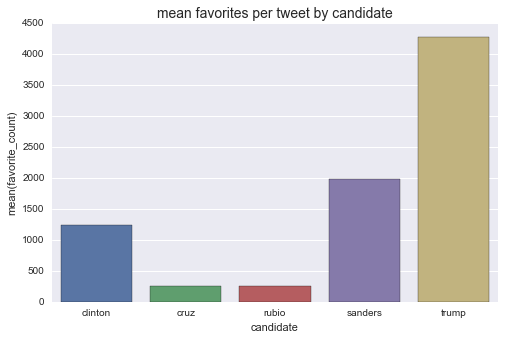

In [137]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'favorite_count', data = favs)
plt.title('mean favorites per tweet by candidate', fontsize = 14)
plt.show()

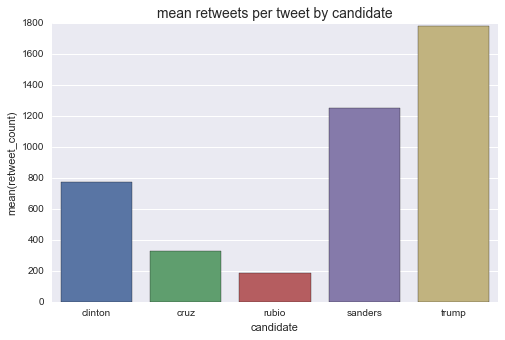

In [135]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'retweet_count', data = favs)
plt.title('mean retweets per tweet by candidate', fontsize = 14)
plt.show()

###  <a id='3'></a>3. Add nlp features

Add sentiment, modality, and mood scores.

In [144]:
# pattern/textblob sentiment reference: http://www.clips.ua.ac.be/pages/pattern-en#sentiment
"""
modality > 0.5 = fact
mood = indicative (fact, belief), imperative (command, warning), conditional (conjecture), subjunctive (wish, opinion)
sentiments = (polarity, subjectivity)
"""


Define functions to tokenize.

In [348]:
def get_sentences(text):
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

def get_sentences2(text):
    """Get number of sentences per review."""
    # add 1 at the end for last punctuation 
    return re.split(". |! |? ", text)
#     return text.count('. ') + text.count('! ') + text.count('? ') + text.count(') ') + \
#             text.count('.\n') + text.count('!\n') + text.count('?\n') + text.count(')\n') + 1.0

In [346]:
def get_polarity(sents):
    """Returns average polarity score for sentences in text."""
    return np.mean([sentiment(x)[0] for x in sents])

def get_is_fact(sents):
    """Returns average modality score for sentences in text."""
    return np.mean([modality(x) for x in sents])

In [347]:
print get_is_fact(t4)

0.75


In [338]:
sentiment(t4)

(0.0, 0.0)

In [239]:
# def tokenize_only(text):
#     # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
#     tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
#     filtered_tokens = []
#     # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
#     for token in tokens:
#         if re.search('[a-zA-Z]', token):
#             filtered_tokens.append(token)
#     return filtered_tokens

In [382]:
# def get_clean_tokens(text):  
#     """Return tokens for each review; exclude stop words and lemmatize."""
#     # letters_only = re.sub("[^a-zA-Z]", " ", text) 
#     words = ' '.join(text.lower().split())
#     #words = ' '.join(split_text.lower().split())
#     tokens = [token.lemma_ for token in nlp(words)]
#     filtered = [t for t in tokens if t not in stop and t != '' and t != ' ' and t != '\n' and t != '\n\n']
#     return ' '.join(filtered)

def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "", text) # remove urls
    letters_only = re.sub("[^a-zA-Z]", " ", text) # remove non alpha characters
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    return ' '.join(filtered)

In [352]:
def get_features(df):
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    
    # add sentiment, modality, and mood scores 
    %time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    %time df.loc[:, 'mood'] = df.loc[:, 'text'].apply(mood)
    %time df.loc[:, 'modality'] = df.loc[:, 'sentences'].apply(get_is_fact)

    return df

In [207]:
nlp = English()

In [214]:
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

In [178]:
print modality(test)
print mood(test)
print sentiment(test)
print wordnet.synsets('sad', ADJECTIVE)[0].weight # for single words only 

0.75
indicative
(0.0, 0.0)
(-0.625, 0.875)


Process tweets df.

In [394]:
tweets2 = get_features(tweets)

CPU times: user 1.77 s, sys: 166 ms, total: 1.94 s
Wall time: 2.14 s
CPU times: user 24.8 s, sys: 737 ms, total: 25.5 s
Wall time: 27.4 s
CPU times: user 6.74 s, sys: 159 ms, total: 6.9 s
Wall time: 7.31 s
CPU times: user 54.6 s, sys: 604 ms, total: 55.2 s
Wall time: 57.3 s
CPU times: user 59.7 s, sys: 323 ms, total: 1min
Wall time: 1min


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [396]:
by_cand = tweets2.groupby('candidate')

In [407]:
total_sentiment = by_cand['sentiment'].sum()
total_sentiment

candidate
clinton    242.871402
cruz       275.265931
rubio      403.753458
sanders    191.709655
trump      440.747906
Name: sentiment, dtype: float64

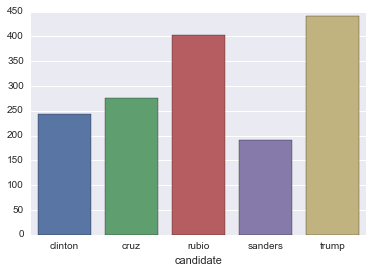

In [408]:
sns.barplot(total_sentiment.index, total_sentiment.values)

In [409]:
avg_sentiment = by_cand['sentiment'].mean()
avg_sentiment

candidate
clinton    0.075286
cruz       0.085833
rubio      0.126015
sanders    0.060381
trump      0.136328
Name: sentiment, dtype: float64

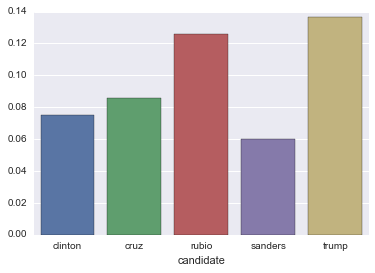

In [410]:
sns.barplot(avg_sentiment.index, avg_sentiment.values)

Investigate mood

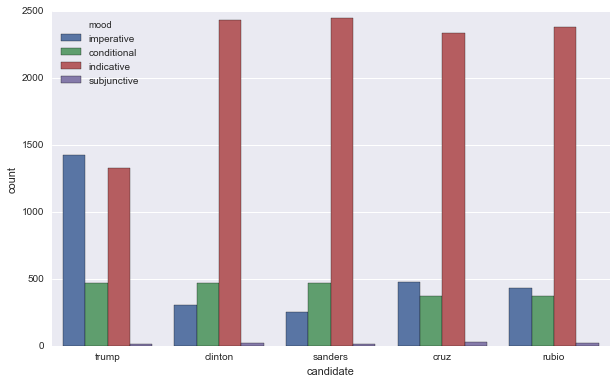

In [402]:
plt.figure(figsize = (10, 6))
sns.countplot('candidate', data = tweets2, hue = 'mood')

### <a id='4'></a>4. Get tf-idf matrix

In [420]:
count_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = 'english', \
                             max_features = 500) 

In [484]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 5, stop_words = 'english',
                                 use_idf = True, tokenizer = None, ngram_range=(4, 4))

In [485]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets2.tokens) 
tfidf_terms = tfidf_vectorizer.get_feature_names()

CPU times: user 778 ms, sys: 27.8 ms, total: 806 ms
Wall time: 805 ms


In [421]:
%time count_matrix = count_vectorizer.fit_transform(tweets2.tokens)

CPU times: user 340 ms, sys: 33.9 ms, total: 374 ms
Wall time: 374 ms


In [439]:

count_words = count_vectorizer.get_feature_names()

### 5. kmeans clustering

In [489]:
def get_clusters(tfidf_matrix, true_k = 5):
    """Fit kmeans cluster model and print clusters given text vector. Return model."""
    km = KMeans(n_clusters = true_k)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(true_k):
        print "Cluster %d:" % i
        for ind in order_centroids[i, :10]:
            print tfidf_terms[ind], ' ',
        print '\n'
    return km

In [491]:
get_clusters(tfidf_matrix)

Cluster 0:
break big fail bank   work long hour low   ia hour iacaucus cruzintocaucus   hour week live poverty   hillary clinton vision just   high impact thing help   help spread message voter   help raise flag new   help celebrate birthday click   help amplify bernie message   

Cluster 1:
rt teammarco watch marcorubio   rt trscoop ted cruz   equal pay equal work   rt hillaryfornh watch live   watch live hillary speak   health care right privilege   defeat radical islamic terrorism   pay family medical leave   rt morning joe berniesanders   border security national security   

Cluster 2:
tell friend hillary clinton   rt need tell friend   need tell friend hillary   guarantee health care right   hillary clinton vision just   high impact thing help   help spread message voter   help raise flag new   help celebrate birthday click   help amplify bernie message   

Cluster 3:
new american century click   ready new american century   american century click gt   work long hour low   gun st

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)